In [1]:
library(reshape2)
install.packages("ggpubr")
library(ggplot2)
install.packages("pheatmap")
library(pheatmap)
library(ggpubr)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Warning message in (function (kind = NULL, normal.kind = NULL, sample.kind = NULL) :
“non-uniform 'Rounding' sampler used”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
### Differential gene expression analysis function

multi_dataset = function(dataset){
names = rownames(dataset)
dataset = apply(dataset, 2, as.character)
dataset = apply(dataset, 2, as.numeric)
rownames(dataset) = names
head(dataset)
  uni = unique(colnames(dataset))
  com = combn(uni, 2, simplify = F)
  print(com)
  for(j in 1:length(com)){
   
    ix = which(colnames(dataset) == com[[j]][1])
   
    ix2 = which( colnames(dataset) == com[[j]][2])
  mat = matrix(0, nrow(dataset), 6)
for(i in 1:nrow(dataset)){
  if((length(which(dataset[i, ix] > 0)) > 1) & (length(which(dataset[i, ix2] > 0)) > 1)){
  mat[i, 4] = t.test(as.numeric(dataset[i, ix]), as.numeric(dataset[i, ix2]))$p.value
}}
  mat[, 5] = p.adjust(mat[, 4], method = "fdr")
 
mean1 = as.numeric(as.character(apply(dataset[, ix], 1, mean, na.rm = T)))
mean2 = as.numeric(as.character(apply(dataset[, ix2], 1, mean, na.rm = T)))

lfc = log2((mean1+0.00000000001)/(mean2+0.00000000001)+1)
higher = mean1 > mean2

mat[, 1] = mean1
mat[, 2] = mean2
mat[, 3]= lfc
mat[, 6] = higher

colnames(mat) = c("Mean1", "Mean2", "logFC", "pval", "FDR-pval", paste("higher_in_", com[[j]][1], sep = ""))
rownames(mat) = rownames(dataset)
write.csv(mat[order(mat[,4]), ], paste("DE_",com[[j]][1], com[[j]][2], sep = "_" ), quote = F)
}}


In [3]:
### lent heatmap pointer script that is publically available (source: https://stackoverflow.com/questions/52599180/partial-row-labels-heatmap-r)


add.flag <- function(pheatmap,
                     kept.labels,
                     repel.degree) {

  # repel.degree = number within [0, 1], which controls how much 
  #                space to allocate for repelling labels.
  ## repel.degree = 0: spread out labels over existing range of kept labels
  ## repel.degree = 1: spread out labels over the full y-axis

  heatmap <- pheatmap$gtable

  new.label <- heatmap$grobs[[which(heatmap$layout$name == "row_names")]] 

  # keep only labels in kept.labels, replace the rest with ""
  new.label$label <- ifelse(new.label$label %in% kept.labels, 
                            new.label$label, "")

  # calculate evenly spaced out y-axis positions
  repelled.y <- function(d, d.select, k = repel.degree){
    # d = vector of distances for labels
    # d.select = vector of T/F for which labels are significant

    # recursive function to get current label positions
    # (note the unit is "npc" for all components of each distance)
    strip.npc <- function(dd){
      if(!"unit.arithmetic" %in% class(dd)) {
        return(as.numeric(dd))
      }

      d1 <- strip.npc(dd$arg1)
      d2 <- strip.npc(dd$arg2)
      fn <- dd$fname
      return(lazyeval::lazy_eval(paste(d1, fn, d2)))
    }

    full.range <- sapply(seq_along(d), function(i) strip.npc(d[i]))
    selected.range <- sapply(seq_along(d[d.select]), function(i) strip.npc(d[d.select][i]))

    return(unit(seq(from = max(selected.range) + k*(max(full.range) - max(selected.range)),
                    to = min(selected.range) - k*(min(selected.range) - min(full.range)), 
                    length.out = sum(d.select)), 
                "npc"))
  }
  new.y.positions <- repelled.y(new.label$y,
                                d.select = new.label$label != "")
  new.flag <- segmentsGrob(x0 = new.label$x,
                           x1 = new.label$x + unit(0.15, "npc"),
                           y0 = new.label$y[new.label$label != ""],
                           y1 = new.y.positions)

  # shift position for selected labels
  new.label$x <- new.label$x + unit(0.2, "npc")
  new.label$y[new.label$label != ""] <- new.y.positions

  # add flag to heatmap
  heatmap <- gtable::gtable_add_grob(x = heatmap,
                                   grobs = new.flag,
                                   t = 4, 
                                   l = 4
  )

  # replace label positions in heatmap
  heatmap$grobs[[which(heatmap$layout$name == "row_names")]] <- new.label

  # plot result
  grid.newpage()
  grid.draw(heatmap)

  # return a copy of the heatmap invisibly
  invisible(heatmap)
}

In [4]:
download.file("https://gdc-hub.s3.us-east-1.amazonaws.com/download/TCGA-PAAD.htseq_fpkm-uq.tsv.gz", "PDAC.tsv.gz"
      )

In [5]:
temp = read.csv(gzfile("PDAC.tsv.gz"), header= T, stringsAsFactors =F, row.names = 1, check.names =F, sep = "\t")

In [6]:
head(temp)

,TCGA-3A-A9IO-01A,TCGA-Z5-AAPL-01A,TCGA-HZ-A49H-01A,TCGA-FB-A4P5-01A,TCGA-FB-AAPS-01A,TCGA-IB-AAUQ-01A,TCGA-HV-A5A5-01A,TCGA-H6-A45N-11A,TCGA-H6-8124-01A,TCGA-IB-7654-01A,⋯,TCGA-IB-7890-01A,TCGA-LB-A9Q5-01A,TCGA-HZ-7924-01A,TCGA-HZ-8002-01A,TCGA-FB-AAPY-01A,TCGA-F2-A44H-01A,TCGA-IB-A5SO-01A,TCGA-FB-AAQ3-01A,TCGA-FB-AAPZ-01A,TCGA-H8-A6C1-01A
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000242268.2,17.04565,9.693558,0.000000,11.023359,10.923589,13.138818,12.842791,9.767561,9.199465,0.000000,⋯,0.000000,10.38100,8.473095,10.56451,9.613139,0.000000,12.088945,0.00000,11.06880,0.000000
ENSG00000270112.3,0.00000,8.431555,6.799139,8.178247,7.084111,7.973076,8.826444,6.928391,0.000000,7.986015,⋯,8.734172,0.00000,7.947407,0.00000,6.775121,7.847837,6.258179,0.00000,0.00000,6.701456
ENSG00000167578.15,17.72522,17.095601,16.887146,17.014995,16.998546,16.500358,16.750299,17.723066,16.333151,15.895757,⋯,15.337835,16.23066,15.625386,15.21133,17.595424,16.849131,16.675413,17.28658,16.29042,17.129134
ENSG00000273842.1,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,⋯,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000
ENSG00000078237.5,17.06160,16.376529,16.452349,16.460069,16.080704,15.965067,16.428086,16.337610,15.691909,18.809419,⋯,16.316664,16.18467,16.302285,16.46972,16.098655,16.092752,16.086007,16.24466,16.48188,16.469228
ENSG00000146083.10,17.44111,18.918192,17.195220,17.800900,17.666034,17.921830,17.868207,19.671673,18.058529,18.881084,⋯,17.795954,17.51043,17.812304,17.37869,18.018869,17.907951,18.186464,17.02037,18.42084,18.299834


In [7]:
### Molecular classifications according Bailey's scheme is retrieved from Rapheal et al 2017. 

### the groups are created on cbioportal's server and could be accessed using this link (https://www.cbioportal.org/comparison?comparisonId=601f6b2ee4b015b63e9d951a)

groups = read.csv("overlap.txt", header= T, stringsAsFactors = F, row.names = 1, check.names = F, sep = "\t")
groups = groups[, -c(1,2)]
mDF = melt(as.matrix(groups))
idx = which(mDF[,3] == "Yes")
groups = data.frame(group = mDF[idx,2], row.names =mDF[idx,1])
head(groups)

,group
,<fct>
TCGA-2J-AAB9-01,adex
TCGA-2J-AABO-01,adex
TCGA-2J-AABR-01,adex
TCGA-2J-AABV-01,adex
TCGA-3A-A9I5-01,adex
TCGA-3A-A9I9-01,adex


In [8]:
### intersect samples from expression data and the groups
colnames(temp) = substr(colnames(temp), 1, 15)
int = intersect(rownames(groups), colnames(temp))
temp = temp[, int]


In [9]:
## convert gene ids to names (using biomart annotations) and only considering genes with expression > 0 in atleast 10 samples

mart = read.table("~/pynb/mart_export.txt", header = T, stringsAsFactors =F, row.names = 1, sep = "\t")
rownames(temp) = gsub("[.][0-9]+$", "", rownames(temp))
names = mart[rownames(temp), 1]
temp = as.matrix(temp)
rownames(temp) = names
head(temp)
ctx = rowSums(temp > 0) > 10
temp2 = temp
temp = temp[ctx, ]




,TCGA-2J-AAB9-01,TCGA-2J-AABO-01,TCGA-2J-AABR-01,TCGA-2J-AABV-01,TCGA-3A-A9I5-01,TCGA-3A-A9I9-01,TCGA-3A-A9IX-01,TCGA-3E-AAAY-01,TCGA-F2-A44H-01,TCGA-F2-A7TX-01,⋯,TCGA-IB-8127-01,TCGA-IB-A5SS-01,TCGA-IB-A6UF-01,TCGA-IB-A7LX-01,TCGA-IB-A7M4-01,TCGA-IB-AAUO-01,TCGA-IB-AAUQ-01,TCGA-S4-A8RO-01,TCGA-XD-AAUL-01,TCGA-YH-A8SY-01
LINC02082,0.00000,12.214093,10.812001,0.00000,14.448691,0.000000,0.000000,9.420932,0.000000,0.00000,⋯,8.413195,9.170795,9.436240,0.000000,0.00000,9.461220,13.138818,11.521534,10.24960,0.00000
AC090241.2,0.00000,8.368753,6.973318,0.00000,9.542262,7.822768,6.341798,6.584530,7.847837,0.00000,⋯,5.589820,0.000000,6.599701,6.504946,0.00000,6.624462,7.973076,8.675169,0.00000,0.00000
RAB4B,16.38902,18.706206,16.182362,16.77738,17.368372,17.764446,15.781612,16.917737,16.849131,16.39056,⋯,16.279843,15.394085,16.344510,16.384861,16.34282,17.418427,16.500358,16.369526,17.57244,16.91302
NA,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,⋯,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000
TIGAR,16.33887,16.742098,16.361370,16.44103,16.836226,16.350504,16.285360,16.229621,16.092752,16.83486,⋯,16.850260,16.354341,15.030609,17.079608,16.08081,16.715609,15.965067,16.704762,16.16957,16.57614
RNF44,18.01464,17.606903,18.089505,16.71792,17.684848,18.100290,18.005745,17.889997,17.907951,18.17737,⋯,18.179129,17.943222,18.267386,18.257485,18.21009,18.478285,17.921830,18.183902,17.96689,17.88442


In [386]:
### Run differential expression analysis betweeen the groups (each group against all others)

id = unique(groups[,1])
for(i in 1:length(id)){
    dataset =temp
    colnames(dataset) = groups[colnames(dataset), 1]
    ix  = which(colnames(dataset) == id[i])
    colnames(dataset)[-ix] = "11_Others"
    multi_dataset(dataset)}

[[1]]
[1] "adex"      "11_Others"

[[1]]
[1] "11_Others"   "immunogenic"

[[1]]
[1] "11_Others"  "progenitor"

[[1]]
[1] "11_Others" "Squamous" 



In [387]:
### process differentially expressed gene list

files = list.files(pattern = "11_Others")
nam = gsub("DE__11_", "", files)
nam = gsub("Others", "", nam)
nam = gsub("_", "", nam)
at = read.csv(files[4], stringsAsFactors = F, header = T )
id = which(at[,7] == 1)
id2 = which(at[,6] < 0.001)
int = intersect(id, id2)
at = at[int, ]
at[,7] = nam[1]
colnames(at)[7] = "Higher in"
for(i in seq(1, 3)){
    at2 = read.csv(files[i], stringsAsFactors = F, header = T)
    idd = which(at2[, 7] == 0)
    idd2 = which(at2[, 6] <  0.001)
    int2 = intersect(idd, idd2)
    at2 = at2[int2, ]
    at2[,7] = nam[i]
    colnames(at2)[7] = "Higher in"

    at = rbind(at, at2)}
new_at = at[-which(is.na(at[,1])),]
head(new_at)
dim(new_at)

,X,Mean1,Mean2,logFC,pval,FDR.pval,Higher in
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
533,RNU6-324P,3.643242,0.1071025,5.129958,0.000000e+00,0.000000e+00,immunogenic
620,REG3A,24.981806,17.0370419,1.302362,5.862140e-30,4.181597e-28,immunogenic
621,REG1CP,17.903114,7.2521489,1.794380,7.172279e-30,5.107910e-28,immunogenic
622,PNLIPRP1,20.510615,11.4276671,1.482756,5.607102e-29,3.986812e-27,immunogenic
623,CTRB2,24.464256,15.0750943,1.391122,3.229467e-28,2.292559e-26,immunogenic
624,CPA2,23.934720,14.8658904,1.384073,1.429222e-27,1.012961e-25,immunogenic


[1] 8123    7

In [388]:
## select top 500 genes from each group and filtering out the NA producing genes 
new_at = new_at[order(new_at[, 6]), ]
c = c()
for(i in 1:length(nam)){
   ic =  grep(nam[i], new_at[,7])
    c = append(c, ic[1:500])
    }
names = new_at[c, 1]
dataset = temp
lt = scale(log2(t(dataset[na.omit(names), ])+1))
revised_names = rownames(na.omit(t(lt)))

### sample annotations
sampleinfo = data.frame(group = groups[colnames(temp), ], row.names =colnames(temp))

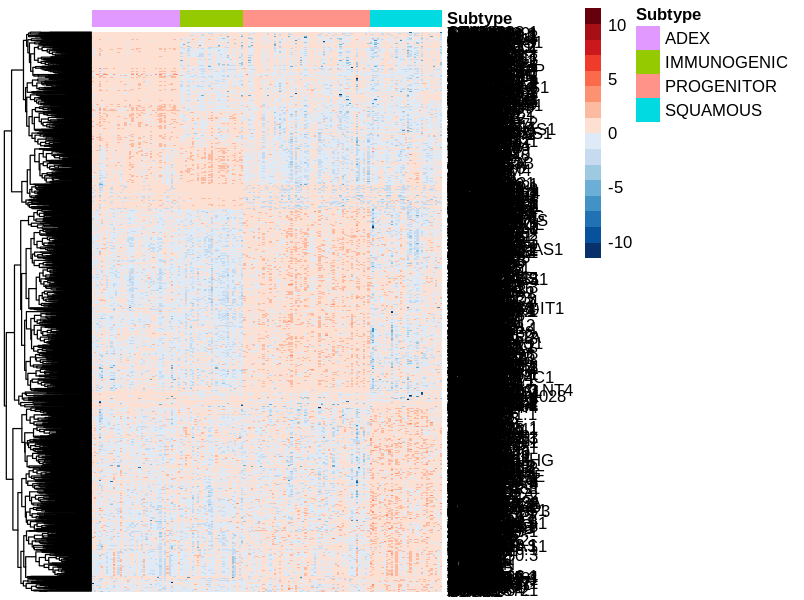

In [58]:
library(RColorBrewer)
options(repr.plot.width=6.7, repr.plot.height=5)

p = pheatmap(log2(dataset[intersect(c(revised_names, "EZR","MUC1", "CLDN15","CLDN3", "DHRS9","MUC20", "SCEL", "TP63", "TP53", "SMAD4", "MYC", "MUC16", "UPK3B", "UPK1B"), rownames(dataset)), ]+1), scale ="row", annotation_col = sampleinfo, col = c(rev(brewer.pal(9, "Blues")[-c(1)]), brewer.pal(9, "Reds")[-c(1)]), cluster_cols = F, show_colnames = F, font.size = 30)

In [395]:
kept = c("EZR","MUC1", "CLDN15","CLDN3", "DHRS9","MUC20","MUC5AC", "MUC4",  "SCEL", "TP63", "TP53", "SMAD4", "MYC", "MUC16", "UPK3B", "UPK1B")

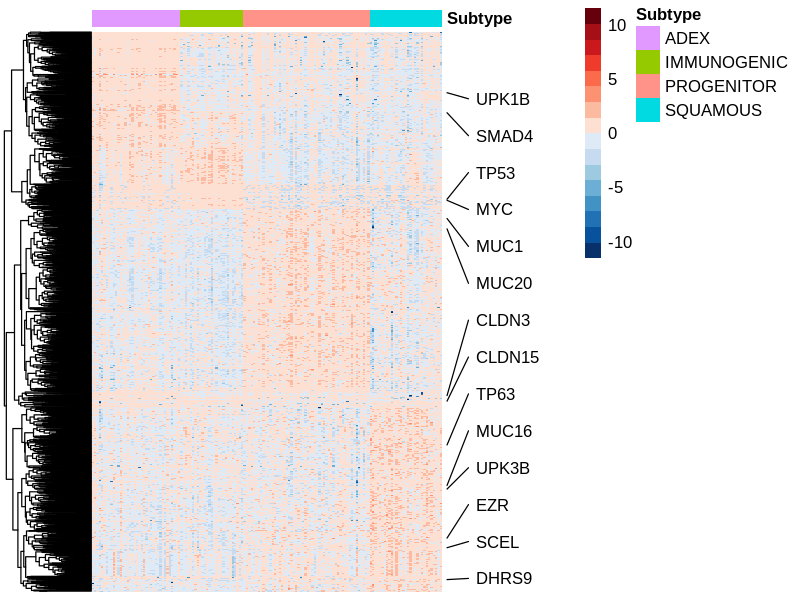

In [60]:
add.flag(p, kept.labels = kept, repel.degree = -0.1)

In [362]:
sampleinfo[,1] = toupper(sampleinfo[,1])
colnames(sampleinfo)[1] = "Subtype"

In [363]:
tsvc = read.csv("~/Downloads/TCGA_data_alterations_heatmap.csv", header= T, stringsAsFactors = F, row.names = 1, sep = "\t")
tsvc = tsvc[, -c(1:3)]

In [364]:
tp53 = read.csv("~/Downloads/tp53_cnv.txt", header= T, stringsAsFactors = F, row.names = 1,sep = "\t")
myc = read.csv("~/Downloads/MYC.txt", header= T, stringsAsFactors = F, row.names = 1,sep = "\t")
cdkn2a = read.csv("~/Downloads/CDKN2A.txt", header= T, stringsAsFactors = F, row.names = 1,sep = "\t")


In [365]:
tsvc$TP53_CNV = tp53[rownames(tsvc), 1]
tsvc$MYC_CNV= myc[rownames(tsvc), 1]
tsvc$CDKN2A_CNV = cdkn2a[rownames(tsvc), 1]

In [366]:
tsvc[,1] = gsub(" .+$", "", tsvc[,1])
tsvc[,2] = gsub(" .+$", "", tsvc[,2])
tsvc[,3] = gsub(" .+$", "", tsvc[,3])
tsvc[,4] = gsub(" .+$", "", tsvc[,4])

tsvc[,1] = gsub("splice_rec", "Splice", tsvc[,1])
tsvc[,2] = gsub("splice_rec", "Splice", tsvc[,2])
tsvc[,3] = gsub("splice_rec", "Splice", tsvc[,3])
tsvc[,4] = gsub("splice_rec", "Splice", tsvc[,4])

In [367]:
colnames(tsvc) = gsub("[.].+$", "", colnames(tsvc))

In [368]:
head(tsvc)

,TP53,SMAD4,CDKN2A,GNAS,TP53_CNV,MYC_CNV,CDKN2A_CNV
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
TCGA-IB-7891,Missense,Missense,,,Deep Deletion,Diploid,Diploid
TCGA-2L-AAQE,Truncating,,Missense,,Shallow Deletion,Amplification,Shallow Deletion
TCGA-OE-A75W,Truncating,,Missense,,Shallow Deletion,Amplification,Shallow Deletion
TCGA-FB-A5VM,Truncating,,,,Diploid,Amplification,Deep Deletion
TCGA-HZ-7922,Truncating,,,,Shallow Deletion,Amplification,Deep Deletion
TCGA-IB-7890,Truncating,,,,Diploid,Amplification,Deep Deletion


In [370]:
rownames(tsvc) = paste(rownames(tsvc), "-01", sep = "")

In [369]:
head(sampleinfo)

,Subtype
,<chr>
TCGA-2J-AAB9-01,ADEX
TCGA-2J-AABO-01,ADEX
TCGA-2J-AABR-01,ADEX
TCGA-2J-AABV-01,ADEX
TCGA-3A-A9I5-01,ADEX
TCGA-3A-A9I9-01,ADEX


In [373]:
idx = intersect(intersect(colnames(temp), rownames(tsvc)), rownames(sampleinfo))

In [372]:

head(temp)

,TCGA-2J-AAB9-01,TCGA-2J-AABO-01,TCGA-2J-AABR-01,TCGA-2J-AABV-01,TCGA-3A-A9I5-01,TCGA-3A-A9I9-01,TCGA-3A-A9IX-01,TCGA-3E-AAAY-01,TCGA-F2-A44H-01,TCGA-F2-A7TX-01,⋯,TCGA-IB-8127-01,TCGA-IB-A5SS-01,TCGA-IB-A6UF-01,TCGA-IB-A7LX-01,TCGA-IB-A7M4-01,TCGA-IB-AAUO-01,TCGA-IB-AAUQ-01,TCGA-S4-A8RO-01,TCGA-XD-AAUL-01,TCGA-YH-A8SY-01
LINC02082,0.00000,12.214093,10.812001,0.00000,14.448691,0.000000,0.000000,9.420932,0.000000,0.00000,⋯,8.413195,9.170795,9.436240,0.000000,0.00000,9.461220,13.138818,11.521534,10.24960,0.00000
AC090241.2,0.00000,8.368753,6.973318,0.00000,9.542262,7.822768,6.341798,6.584530,7.847837,0.00000,⋯,5.589820,0.000000,6.599701,6.504946,0.00000,6.624462,7.973076,8.675169,0.00000,0.00000
RAB4B,16.38902,18.706206,16.182362,16.77738,17.368372,17.764446,15.781612,16.917737,16.849131,16.39056,⋯,16.279843,15.394085,16.344510,16.384861,16.34282,17.418427,16.500358,16.369526,17.57244,16.91302
TIGAR,16.33887,16.742098,16.361370,16.44103,16.836226,16.350504,16.285360,16.229621,16.092752,16.83486,⋯,16.850260,16.354341,15.030609,17.079608,16.08081,16.715609,15.965067,16.704762,16.16957,16.57614
RNF44,18.01464,17.606903,18.089505,16.71792,17.684848,18.100290,18.005745,17.889997,17.907951,18.17737,⋯,18.179129,17.943222,18.267386,18.257485,18.21009,18.478285,17.921830,18.183902,17.96689,17.88442
DNAH3,11.37372,12.138890,10.170191,10.23791,5.441216,11.151919,10.505074,11.109794,7.884900,11.62604,⋯,13.825690,12.189304,12.359211,11.655926,12.28058,13.375044,11.327035,12.647682,11.87402,11.48268


In [ ]:

add.flag(p, kept.labels = kept, repel.degree = -0.1)

In [374]:
sampleinfo[,1] = as.factor(sampleinfo[,1])
sampleinfo[,1] = relevel(sampleinfo[,1], ref = "IMMUNOGENIC")

In [405]:
ft = unique(as.character(as.matrix(tsvc)))
ft = ft[c(1:9, 11, 10)]
ann_cols = list()
ann_cols = append(ann_cols, list(unique(sampleinfo[,1])))
ann_cols = append(ann_cols, list(ft))
ann_cols = append(ann_cols, list(ft))
ann_cols = append(ann_cols, list(ft))
ann_cols = append(ann_cols, list(ft))
ann_cols = append(ann_cols, list(ft))
ann_cols = append(ann_cols, list(ft))
ann_cols = append(ann_cols, list(ft))


In [406]:
ann_cols2 = list()
rus = "Royal1"
rus2 = "Rushmore1"

ann_cols2 = append(ann_cols2, list(brewer.pal(4, "Set3")))
ann_cols2 = append(ann_cols2, list(c(wes_palette(rus)[1:5], wes_palette(rus2)[1:5], "#343434")))
ann_cols2 = append(ann_cols2, list(c(wes_palette(rus)[1:5], wes_palette(rus2)[1:5], "#343434")))
ann_cols2 = append(ann_cols2, list(c(wes_palette(rus)[1:5], wes_palette(rus2)[1:5], "#343434")))
ann_cols2 = append(ann_cols2, list(c(wes_palette(rus)[1:5], wes_palette(rus2)[1:5], "#343434")))
ann_cols2 = append(ann_cols2, list(c(wes_palette(rus)[1:5], wes_palette(rus2)[1:5], "#343434")))
ann_cols2 = append(ann_cols2, list(c(wes_palette(rus)[1:5], wes_palette(rus2)[1:5], "#343434")))
ann_cols2 = append(ann_cols2, list(c(wes_palette(rus)[1:5], wes_palette(rus2)[1:5], "#343434")))


In [407]:
names(ann_cols2[[1]])= ann_cols[[1]]
names(ann_cols2[[2]])= ann_cols[[2]]
names(ann_cols2[[3]])= ann_cols[[3]]
names(ann_cols2[[4]])= ann_cols[[4]]
names(ann_cols2[[5]])= ann_cols[[5]]
names(ann_cols2[[6]])= ann_cols[[6]]
names(ann_cols2[[7]])= ann_cols[[7]]
names(ann_cols2[[8]])= ann_cols[[8]]

In [408]:
names(ann_cols2) = colnames(tsvc)[c(8,1:7)]

In [409]:
colnames(tsvc)
dataset = temp

[1] "TP53"       "SMAD4"      "CDKN2A"     "GNAS"       "TP53_CNV"  
[6] "MYC_CNV"    "CDKN2A_CNV" "Subtype"

In [410]:
tsvc$Subtype = 0
tsvc[idx, 8] = as.character(sampleinfo[idx, 1])

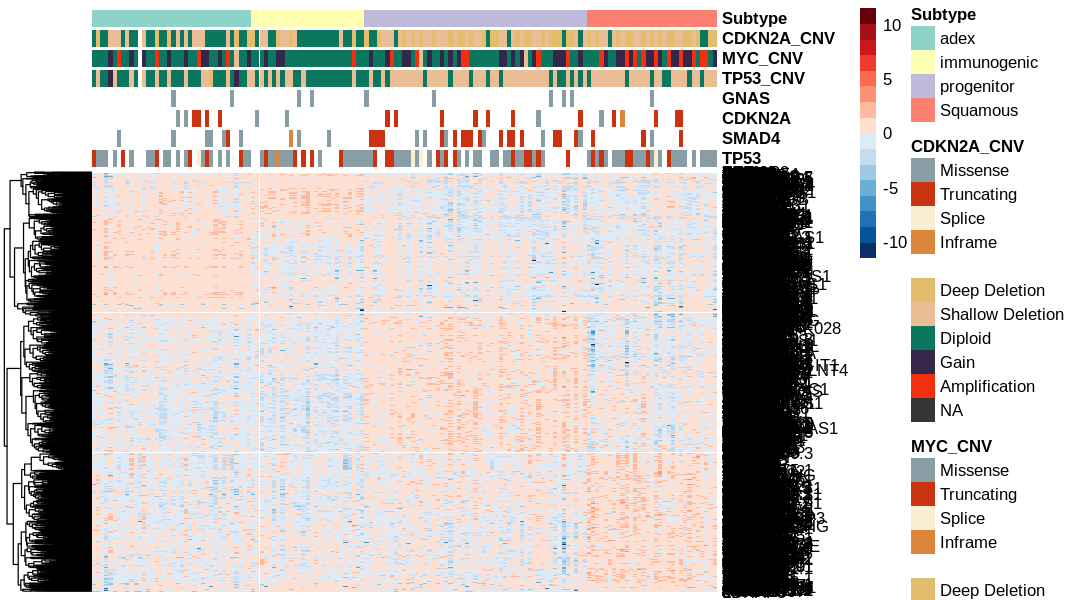

In [411]:
options(repr.plot.width=9, repr.plot.height=5)

p = pheatmap(log2(dataset[intersect(c(revised_names, "EZR","MUC1", "CLDN15","CLDN3", "DHRS9","MUC20", "SCEL", "TP63", "TP53", "SMAD4", "MYC", "MUC16", "UPK3B", "UPK1B"), rownames(dataset)), idx]+1), scale ="row",  col = c(rev(brewer.pal(9, "Blues")[-c(1)]), brewer.pal(9, "Reds")[-c(1)]), cluster_cols = F, show_colnames = F, font.size = 30, annotation_col = tsvc, annotation_colors = ann_cols2)

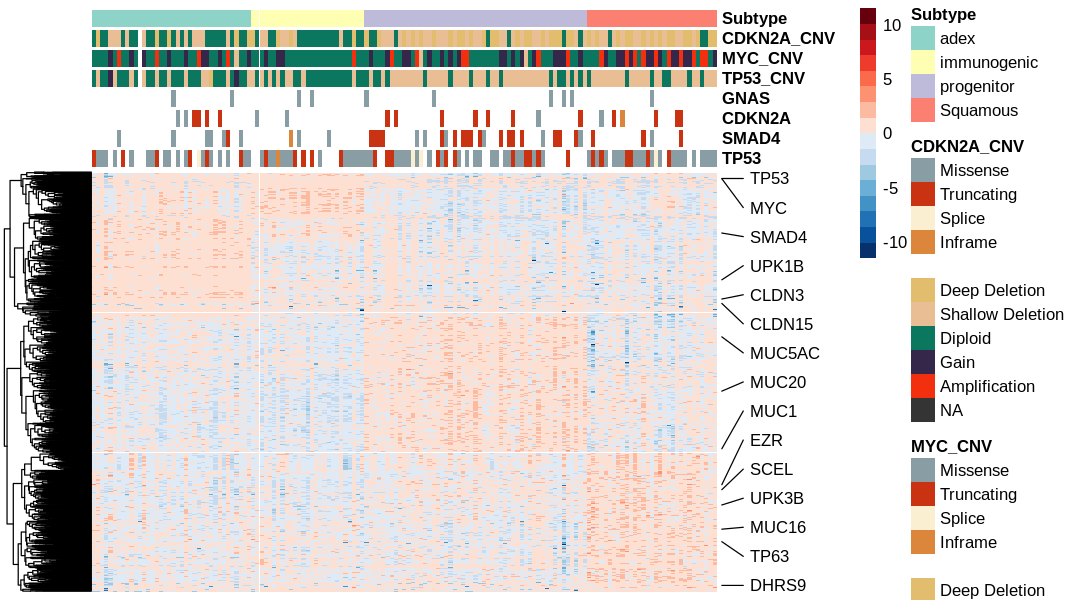

In [412]:
library(grid)
p = add.flag(p, kept.labels = kept, repel.degree = 0)



In [278]:
pdf("~/test.pdf", width = 9, height = 5)
grid.draw(p)
dev.off()

png 
  2

In [413]:
smad4 = read.csv("~/Downloads/SMAD4.txt", header= T, stringsAsFactors = F, row.names = 1,sep = "\t")

In [414]:
tsvc$SMAD4_CNV = ""

In [415]:
tsvc[idx, 9] = smad4[idx, 1]

In [416]:
ann_cols2 = append(ann_cols2, list(c(wes_palette(rus)[1:5], wes_palette(rus2)[1:5], "#343434")))
names(ann_cols2[[8]])= ann_cols[[8]]
names(ann_cols2[[9]]) = names(ann_cols2[[8]])

In [417]:
names(ann_cols2)[[9]] = "SMAD4_CNV"

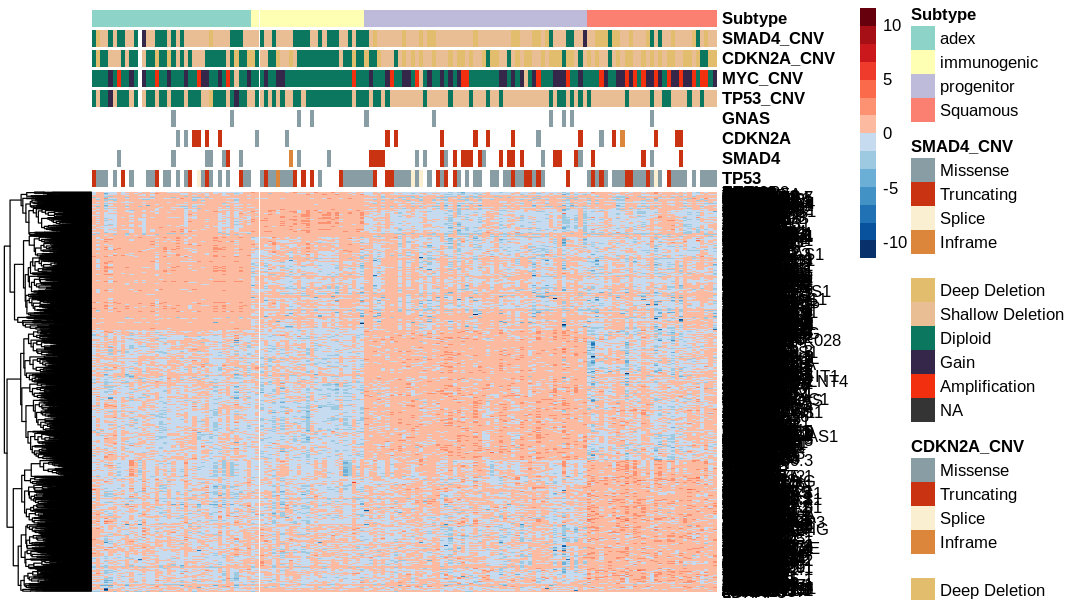

In [418]:
options(repr.plot.width=9, repr.plot.height=5)

imm = rownames(sampleinfo)[which(sampleinfo[,1] == "IMMUNOGENIC")]
imm = intersect(idx, imm)
sd = setdiff(idx, imm)

p = pheatmap(log2(dataset[intersect(c(revised_names, "EZR","MUC1", "CLDN15","CLDN3", "DHRS9","MUC20", "SCEL", "TP63", "TP53", "SMAD4", "MYC", "MUC16", "UPK3B", "UPK1B"), rownames(dataset)), c(imm, sd)]+1), scale ="row",  col = c(rev(brewer.pal(9, "Blues")[-c(1,2)]), brewer.pal(9, "Reds")[-c(1,2)]), cluster_cols = F, show_colnames = F, font.size = 30, annotation_col = tsvc[c(1:7,9,8)], annotation_colors = ann_cols2)

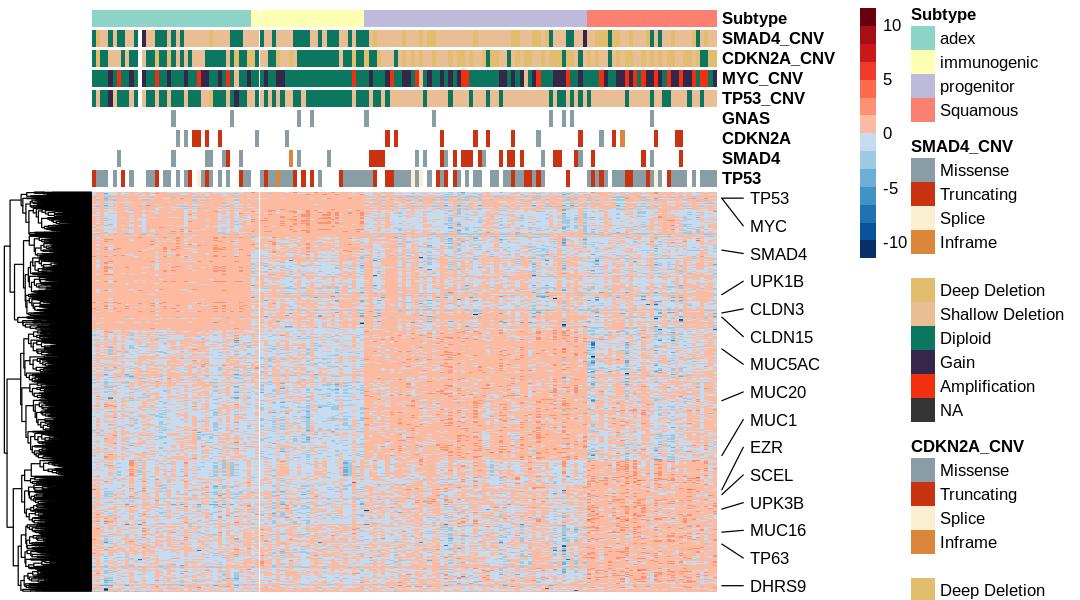

In [419]:

p = add.flag(p, kept.labels = kept, repel.degree = 0)


In [423]:
kras = read.csv("~/Downloads/plot (73).txt", header= T, stringsAsFactors = F, row.names = 1,sep = "\t")
head(kras)

,KRAS..Mutations,KRAS..mRNA.expression..RNA.Seq.V2.RSEM.
,<chr>,<dbl>
TCGA-2J-AAB1-01,Missense,1030.2439
TCGA-2J-AAB4-01,Missense,894.3603
TCGA-2J-AAB6-01,Missense,1606.4327
TCGA-2J-AAB8-01,Missense,1377.2033
TCGA-2J-AAB9-01,Missense,1285.1018
TCGA-2J-AABE-01,Missense,912.5944


In [424]:
kras[,1] = as.factor(kras[,1])
levels(kras[,1]) = c("Missense", "", NA)
tsvc$KRAS = ""
idx = intersect(rownames(kras), rownames(tsvc))
tsvc[idx, 10] = as.character(kras[idx, 1])


In [427]:
ann_cols2 = append(ann_cols2, list(c(wes_palette(rus)[1:5], wes_palette(rus2)[1:5], "#343434")))
names(ann_cols2)[[10]] = "KRAS_MUT"
names(ann_cols2[[10]]) = names(ann_cols2[[9]])

In [438]:
colnames(tsvc)[1:4] = paste(colnames(tsvc)[1:4], "_MUT", sep = "")
colnames(tsvc)[ncol(tsvc)] = paste(colnames(tsvc)[ncol(tsvc)], "_MUT", sep = "")


In [441]:
names(ann_cols2)[2:5] = paste(names(ann_cols2)[2:5], "_MUT", sep = "")
names(ann_cols2)

[1] "Subtype"    "TP53_MUT"   "SMAD4_MUT"  "CDKN2A_MUT" "GNAS_MUT"  
 [6] "TP53_CNV"   "MYC_CNV"    "CDKN2A_CNV" "SMAD4_CNV"  "KRAS_MUT"

In [442]:
colnames(tsvc)

[1] "TP53_MUT"   "SMAD4_MUT"  "CDKN2A_MUT" "GNAS_MUT"   "TP53_CNV"  
 [6] "MYC_CNV"    "CDKN2A_CNV" "Subtype"    "SMAD4_CNV"  "KRAS_MUT"

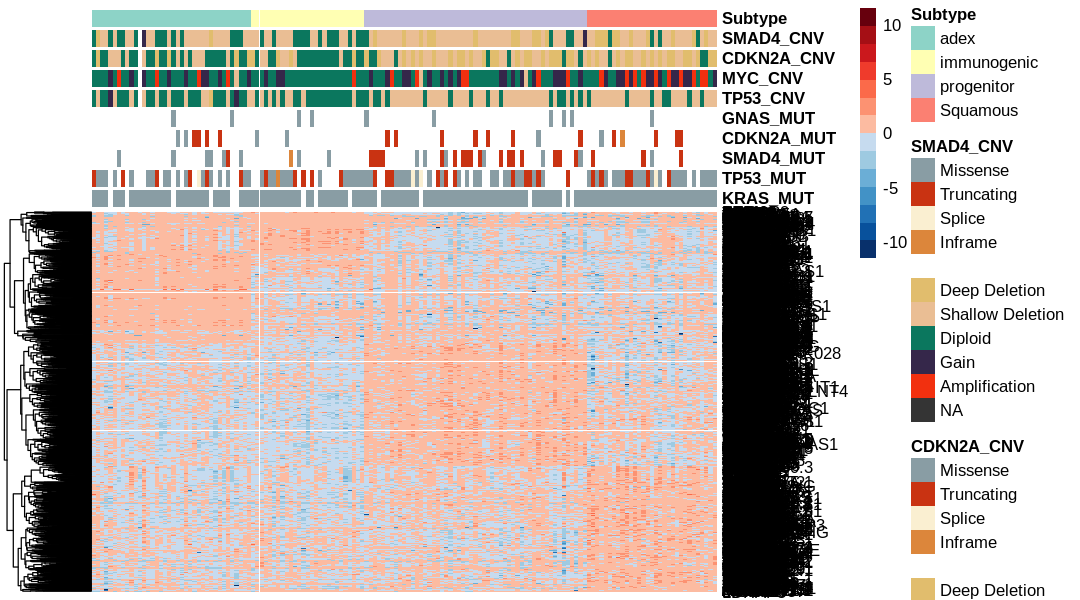

In [444]:
p = pheatmap(log2(dataset[intersect(c(revised_names, "EZR","MUC1", "CLDN15","CLDN3", "DHRS9","MUC20", "SCEL", "TP63", "TP53", "SMAD4", "MYC", "MUC16", "UPK3B", "UPK1B"), rownames(dataset)), c(imm, sd)]+1), scale ="row",  col = c(rev(brewer.pal(9, "Blues")[-c(1,2)]), brewer.pal(9, "Reds")[-c(1,2)]), cluster_cols = F, show_colnames = F, font.size = 30, annotation_col = tsvc[c(10,1:7,9,8)], annotation_colors = ann_cols2)

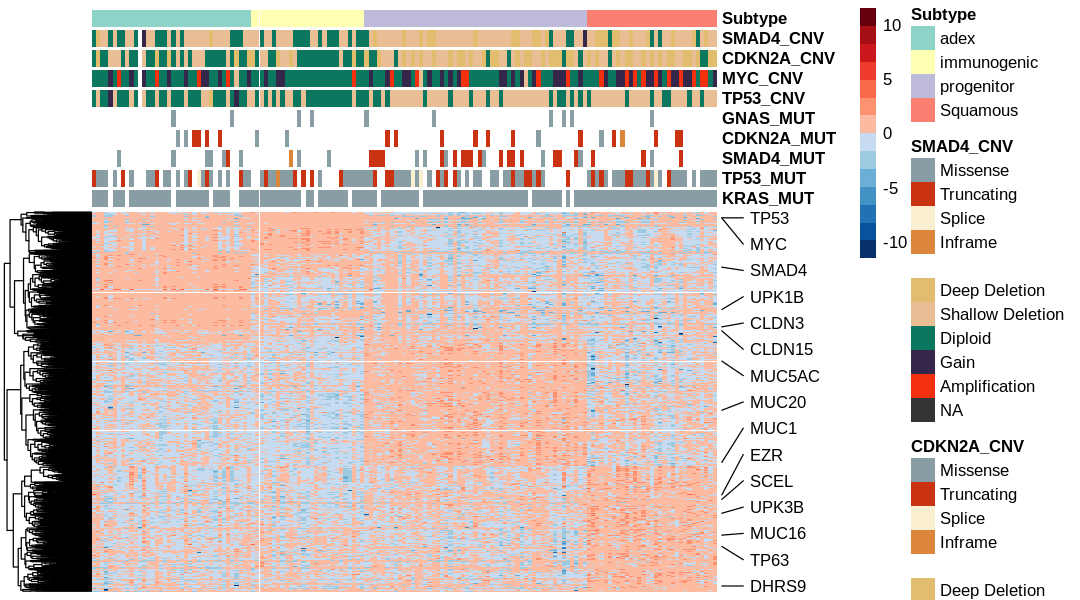

In [445]:
p = add.flag(p, kept.labels = kept, repel.degree = 0)


In [323]:
pdf("~/test.pdf", width = 9, height = 5)
grid.draw(p)
dev.off()

png 
  2

In [43]:
int = intersect(colnames(temp), rownames(groups))
ABS = cbind(temp["MUC16", int ], as.character(groups[int, ]))
colnames(ABS) = c("MUC16", "Subtype")
ABS[,2] = toupper(ABS[,2])
ABS = as.data.frame(ABS)
ABS[,1] = as.numeric(ABS[,1])


Warning message in (function (kind = NULL, normal.kind = NULL, sample.kind = NULL) :
“non-uniform 'Rounding' sampler used”


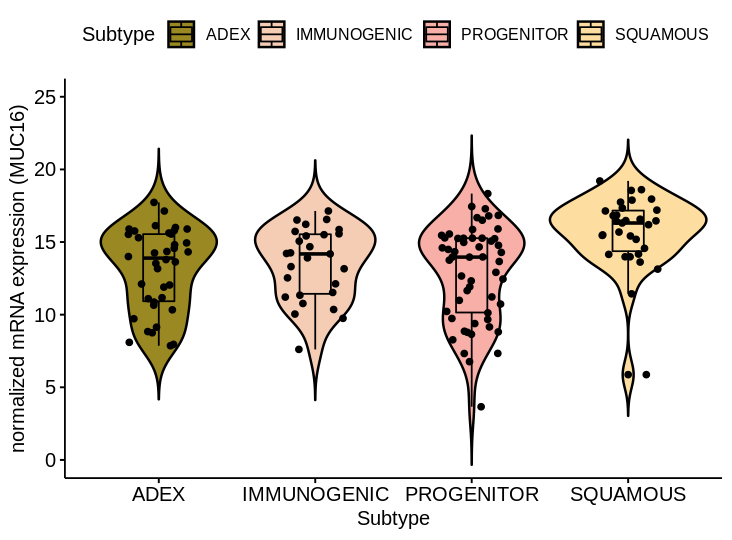

In [91]:
options(repr.plot.width=6.1, repr.plot.height=4.5)

p = ggviolin(ABS,x="Subtype",y="MUC16", fill = "Subtype", 
          notch = F, add = c("boxplot", "jitter"), palette = wes_palette("Royal2"),ylim = c(0,25), size =0.7, ylab = "normalized mRNA expression (MUC16)")

p

In [92]:
library(wesanderson)

Warning message in (function (kind = NULL, normal.kind = NULL, sample.kind = NULL) :
“non-uniform 'Rounding' sampler used”


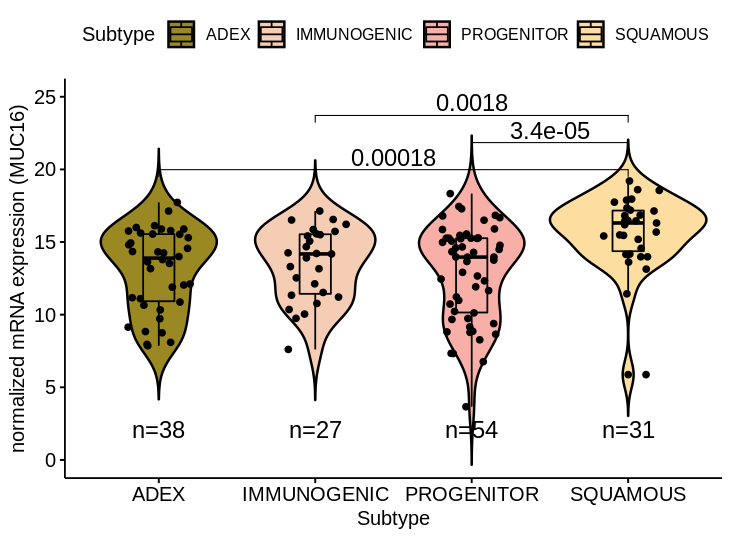

In [93]:
comp = list(c("SQUAMOUS", "ADEX"), c("SQUAMOUS", "PROGENITOR"), c("SQUAMOUS", "IMMUNOGENIC"))
p = p + stat_compare_means( label = "p.format", method = "t.test", comparisons = comp,size = 5)
p = p +stat_n_text(size = 5)
p

In [94]:
comp = combn(unique(ABS[,2]), 2)

In [95]:
comp = list(c("SQUAMOUS", "ADEX"), c("SQUAMOUS", "PROGENITOR"), c("SQUAMOUS", "IMMUNOGENIC"))

Warning message in (function (kind = NULL, normal.kind = NULL, sample.kind = NULL) :
“non-uniform 'Rounding' sampler used”


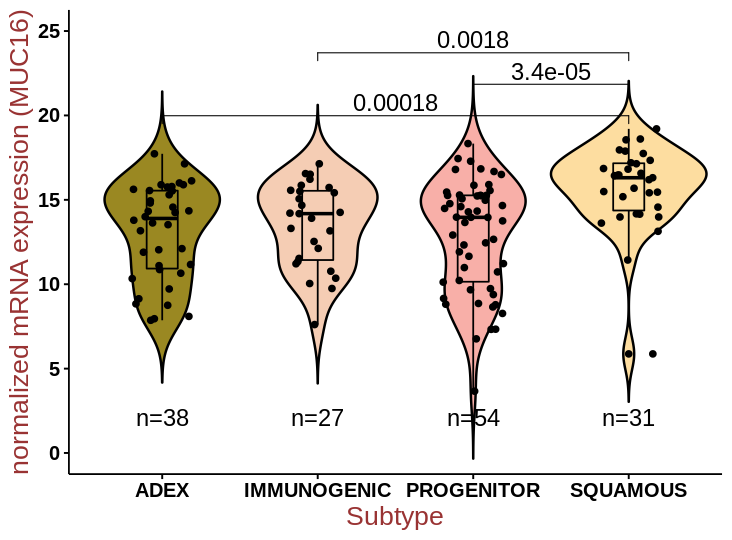

In [96]:
p + font("title", size = 14, color = "red", face = "bold.italic")+
 font("subtitle", size = 10, color = "Black")+
 font("caption", size = 10, color = "Black")+
 font("xlab", size = 16, color = "#993333")+
 font("ylab", size = 16, color = "#993333")+
 font("xy.text", size = 12,  face = "bold")+ theme(legend.position="none")


In [97]:
### sample weight and other variables

In [222]:
apt = read.csv("~/Downloads/plot (70).txt", header= T, stringsAsFactors = F, row.names = 1, sep = "\t", check.names = F)

In [223]:
apt2 = read.csv("~/Downloads/plot (71).txt", header= T, stringsAsFactors = F, row.names = 1, sep = "\t", check.names = F)

In [224]:
lt = cbind(apt, apt2[rownames(apt), ])

In [225]:
pt = lt[, c(1,2,4,ncol(lt))]
pt[,2] = as.numeric(pt[,2])

In [226]:
pt$MUC16 = "No"
colnames(pt)
ct = which(pt[,2] >=2)
pt[ct, "MUC16"] = "Yes"

[1] "Tumor resected max dimension"                                                 
[2] "MUC16: mRNA expression z-scores relative to diploid samples (RNA Seq V2 RSEM)"
[3] "Fraction Genome Altered"                                                      
[4] "Sample Initial Weight"                                                        
[5] "MUC16"

In [227]:
pt = pt[, -2]

In [228]:
length(which(lt[,2] > 1))

[1] 21

Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 rows containing non-finite values (stat_compare_means).”
Warning message:
“Removed 1 rows containing non-finite values (stat_n_text).”
Warning message in (function (kind = NULL, normal.kind = NULL, sample.kind = NULL) :
“non-uniform 'Rounding' sampler used”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


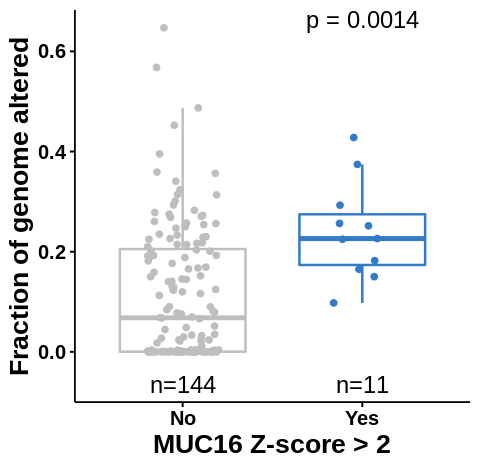

In [239]:
options(repr.plot.width=4, repr.plot.height=3.9)
pt[,2] = as.numeric(pt[,2])
p = ggboxplot(pt,x="MUC16",y="Fraction Genome Altered", color = "MUC16",palette = c( "Gray", "#327bc9"),
          notch = F, add = c("jitter"),  size =0.7, ylab = "Fraction of genome altered", xlab = "MUC16 Z-score > 2")

p = p + stat_compare_means( label = "p.format", method = "t.test", ref = "No", size = 5)
p = p +stat_n_text(size = 5)
p + font("title", size = 14, color = "red", face = "bold.italic")+
 font("subtitle", size = 10, color = "Black")+
 font("caption", size = 10, color = "Black")+
 font("xlab", size = 16, color = "Black", face = "bold")+
 font("ylab", size = 16, color = "Black",face = "bold")+
 font("xy.text", size = 12,  face = "bold")+ theme(legend.position="none")


Warning message in (function (kind = NULL, normal.kind = NULL, sample.kind = NULL) :
“non-uniform 'Rounding' sampler used”


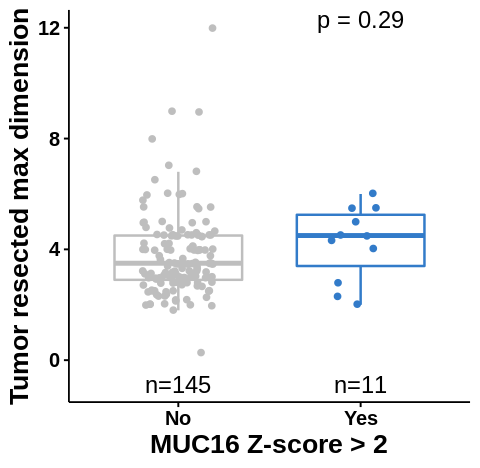

In [238]:
options(repr.plot.width=4, repr.plot.height=3.9)
pt[,3] = as.numeric(pt[,3])
p = ggboxplot(pt,x="MUC16",y="Tumor resected max dimension", color = "MUC16",palette = c("Gray", "#327bc9"),
          notch = F, add = c("jitter"),  size =0.7, ylab = "Tumor resected max dimension", xlab = "MUC16 Z-score > 2")

p = p + stat_compare_means( label = "p.format", method = "t.test", ref = "No", size = 5)
p = p +stat_n_text(size = 5)
p + font("title", size = 14, color = "red", face = "bold.italic")+
 font("subtitle", size = 10, color = "Black")+
 font("caption", size = 10, color = "Black")+
 font("xlab", size = 16, color = "Black", face = "bold")+
 font("ylab", size = 16, color = "Black",face = "bold")+
 font("xy.text", size = 12,  face = "bold")+ theme(legend.position="none")


Warning message:
“Removed 43 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 43 rows containing non-finite values (stat_compare_means).”
Warning message:
“Removed 43 rows containing non-finite values (stat_n_text).”
Warning message in (function (kind = NULL, normal.kind = NULL, sample.kind = NULL) :
“non-uniform 'Rounding' sampler used”
Warning message:
“Removed 43 rows containing missing values (geom_point).”


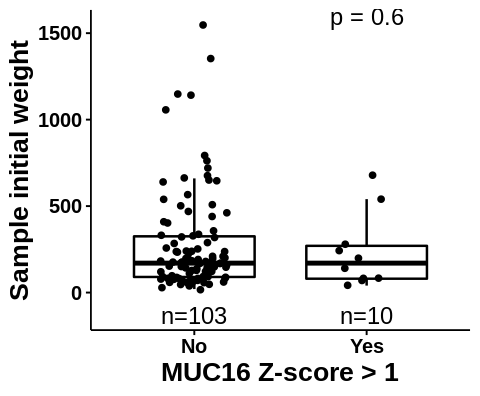

In [231]:
options(repr.plot.width=4, repr.plot.height=3.3)
pt[,1] = as.numeric(pt[,1])
p = ggboxplot(pt,x="MUC16",y="Sample Initial Weight", 
          notch = F, add = c("jitter"),  size =0.7, ylab = "Sample initial weight", xlab = "MUC16 Z-score > 1")

p = p + stat_compare_means( label = "p.format", method = "t.test", ref = "No", size = 5)
p = p +stat_n_text(size = 5)
p + font("title", size = 14, color = "red", face = "bold.italic")+
 font("subtitle", size = 10, color = "Black")+
 font("caption", size = 10, color = "Black")+
 font("xlab", size = 16, color = "Black", face = "bold")+
 font("ylab", size = 16, color = "Black",face = "bold")+
 font("xy.text", size = 12,  face = "bold")+ theme(legend.position="none")